In [1]:
import gempyor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob, os, sys, re, shutil
from pathlib import Path

# import seaborn as sns
import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import click
import subprocess
import dask.dataframe as dd
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.backends.backend_pdf import PdfPages


data_dir = "RSV_USA/"
import os
os.chdir(data_dir)
data_dir = "."  # necessary for now for time serie parameters !!! fixme 

### Setup manual

In [2]:
config_path = f"config_rsv_simplified_inference_v3_MD.yml"
run_id = "config_rsv_simplified_inference_v3_MD.yml"

In [3]:

#fs_results_path = "model_output" 
#
#run_info = RunInfo(run_id = run_id, 
#                   config_path= f"{data_dir}/{config_name}",
#                   folder_path = f"{fs_results_path}")
#
#run_info.gempyor_simulator = gempyor.GempyorSimulator(
#    config_path=run_info.config_path,
#    run_id=run_info.run_id,
#    #prefix=f"USA/inference/med/{run_id}/global/intermediate/000000001.",
#    seir_modifiers_scenario="none",
#    outcome_modifiers_scenario="IHRadj",
#    first_sim_index=1,
#    stoch_traj_flag=False,
#    spatial_path_prefix=f"{data_dir}/",  # prefix where to find the folder indicated in spatial_setup$
#)
#
##run_info.gempyor_simulator.update_prefix(new_prefix=f"config_rsv_simplified_inference_v3_MD/{run_id}")
#node_names = run_info.gempyor_simulator.modinf.subpop_struct.subpop_names

In [4]:

import logging
import os
import multiprocessing as mp
import pandas as pd
import pyarrow.parquet as pq
from gempyor import config, model_info, outcomes, seir


logging.basicConfig(level=os.environ.get("FLEPI_LOGLEVEL", "INFO").upper())
logger = logging.getLogger()
handler = logging.StreamHandler()
# '%(asctime)s %(name)-12s %(levelname)-8s %(message)s'
formatter = logging.Formatter(
    " %(name)s :: %(levelname)-8s :: %(message)s"
    # "%(asctime)s [%(filename)s:%(lineno)s - %(funcName)20s() ] %(message)s"
)

handler.setFormatter(formatter)

seir_modifiers_scenario="none"
outcome_modifiers_scenario="IHRadj"

in_run_id = run_id
out_run_id = in_run_id
in_prefix = "emcee"

out_prefix = in_prefix

        # Config prep
config.clear()
config.read(user=False)
config.set_file(config_path)
print(config_path)


write_csv = False
write_parquet = True
modinf = model_info.ModelInfo(
    config=config,
    nslots=1,
    seir_modifiers_scenario=seir_modifiers_scenario,
    outcome_modifiers_scenario=outcome_modifiers_scenario,
    write_csv=write_csv,
    write_parquet=write_parquet,
    first_sim_index=1,
    in_run_id=in_run_id,
    in_prefix=in_prefix,
    inference_filename_prefix="no",
    inference_filepath_suffix="no",
    out_run_id=out_run_id,
    out_prefix=out_prefix,
    stoch_traj_flag=False,
)

(
    unique_strings,
    transition_array,
    proportion_array,
    proportion_info,
) = modinf.compartments.get_transition_array()

outcomes_parameters = outcomes.read_parameters_from_config(modinf)


npi_seir = seir.build_npi_SEIR(
    modinf=modinf, load_ID=False, sim_id2load=None, config=config
)
if modinf.npi_config_outcomes:
    npi_outcomes = outcomes.build_outcome_modifiers(
                modinf=modinf,
                load_ID=False,
                sim_id2load=None,
                config=config,
            )

p_draw = modinf.parameters.parameters_quick_draw(
                n_days=modinf.n_days, nsubpops=modinf.nsubpops
            )

initial_conditions = modinf.initial_conditions.draw(sim_id=0, setup=modinf)
seeding_data, seeding_amounts = modinf.seeding.draw(sim_id=0, setup=modinf)



# reduce them
parameters = modinf.parameters.parameters_reduce(p_draw, npi_seir)
        # Parse them
parsed_parameters = modinf.compartments.parse_parameters(
    parameters, modinf.parameters.pnames, unique_strings
)

states = seir.steps_SEIR(
    modinf,
    parsed_parameters,
    transition_array,
    proportion_array,
    proportion_info,
    initial_conditions,
    seeding_data,
    seeding_amounts,
)

seir_out_df_ref = seir.postprocess_and_write(
    0, modinf, states, p_draw, npi_seir, seeding_data
)
snpi_df_ref = npi_seir.getReductionDF()

outcomes_df, hpar_df = outcomes.compute_all_multioutcomes(
    modinf=modinf,
    sim_id2write=0,
    parameters=outcomes_parameters,
    loaded_values=None,
    npi=npi_outcomes,
    bypass_seir=seir_out_df_ref
)
outcomes_df_ref, hpar_ref, hnpi_df_ref = outcomes.postprocess_and_write(
    sim_id=0,
    modinf=modinf,
    outcomes_df=outcomes_df,
    hpar=hpar_df,
    npi=npi_outcomes,
)

CRITICAL:root:No mobility matrix specified -- assuming no one moves


config_rsv_simplified_inference_v3_MD.yml


INFO:root:[SEIR.compartments] completed in 1.16 s
INFO:root:[Outcome.structure] completed in 0.00 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
/Users/chadi/Research/FlepiMoP_Projects/flepiMoP/flepimop/gempyor_pkg/src/gempyor/seeding_ic.py:492: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y0[comp_idx, pl_idx] = float(ic_df_compartment_val)
INFO:root:Integrating with method rk4.jit
13819it [00:22, 606.34it/s]


<Axes: xlabel='date'>

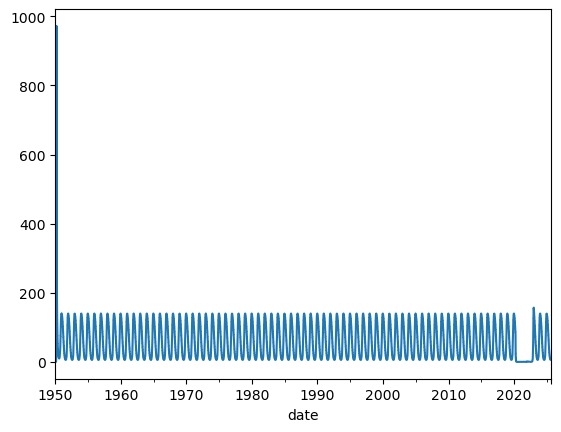

In [5]:
outcomes_df_ref.set_index("date")["incidH"].plot()

In [13]:
# reprocess:
npi_seir = seir.build_npi_SEIR(
    modinf=modinf, load_ID=False, sim_id2load=None, config=config, 
    bypass_DF=snpi_df_ref
)
if modinf.npi_config_outcomes:
    npi_outcomes = outcomes.build_outcome_modifiers(
                modinf=modinf,
                load_ID=False,
                sim_id2load=None,
                config=config,
                bypass_DF=hnpi_df_ref
            )
    

# reduce them
parameters = modinf.parameters.parameters_reduce(p_draw, npi_seir)
        # Parse them
parsed_parameters = modinf.compartments.parse_parameters(
    parameters, modinf.parameters.pnames, unique_strings
)

states = seir.steps_SEIR(
    modinf,
    parsed_parameters,
    transition_array,
    proportion_array,
    proportion_info,
    initial_conditions,
    seeding_data,
    seeding_amounts,
)

seir_out_df = seir.postprocess_and_write(
    0, modinf, states, p_draw, npi_seir, seeding_data
)

outcomes_df, hpar_df = outcomes.compute_all_multioutcomes(
    modinf=modinf,
    sim_id2write=0,
    parameters=outcomes_parameters,
    loaded_values=None,
    npi=npi_outcomes,
    bypass_seir=seir_out_df
)
outcomes_df, hpar, hnpi = outcomes.postprocess_and_write(
    sim_id=0,
    modinf=modinf,
    outcomes_df=outcomes_df,
    hpar=hpar_df,
    npi=npi_outcomes,
)


INFO:root:[SEIR.NPI] completed in 0.18 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
13819it [00:22, 625.91it/s]


<Axes: xlabel='date'>

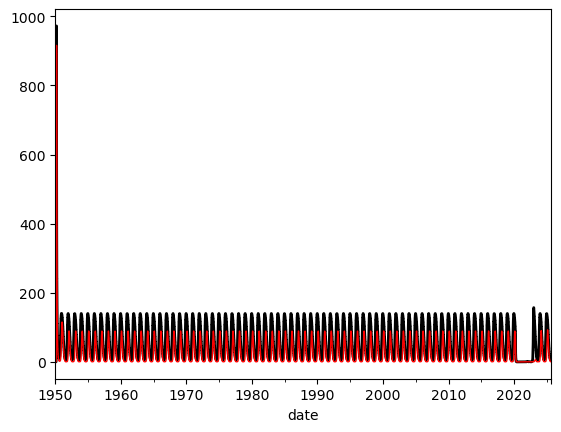

In [14]:
outcomes_df_ref.set_index("date")["incidH"].plot(lw=2, c='k')
outcomes_df.set_index("date")["incidH"].plot(lw=1, c='r')